## Import statements

In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt

from numpy import vstack, dot, array
from pylab import rcParams
from scipy.ndimage import imread
from skimage.transform import warp
from numpy.linalg import inv, lstsq

#ipython setting
rcParams['figure.figsize'] = (20, 12)

$\newcommand{\vecl}[1]{\begin{pmatrix}#1\end{pmatrix}}$ 
$\newcommand{\hvec}[1]{\widetilde{\boldsymbol{#1}}}$
$\newcommand{\nvec}[1]{\boldsymbol{#1}}$

## Affine transforms

The following code section deines a function affineTransformation which transforms an input image 'f' with an affine transformation to an image f_transf. This is done by making use of homogeneous coordinates where a datavector in 2D image space is appended with a 3rd component, a scaling factor 's' (often taken as s=1). This gives

\begin{split} 
\nvec{x} = \vecl{a\\b} \quad \Rightarrow \quad \hvec{x} = \vecl{s\nvec{x}\\s} 
\end{split}

where $\hvec{x}$ denotes the new homogeneous vector. of course, to get back the original datavector from this representation, the inverse can be performed on $\hvec{x}$

\begin{split}
\hvec{x} = \vecl{a\\b\\c}  \quad \Rightarrow \quad
\nvec{x} = \vecl{a/c \\ b/c}
\end{split}

An affine transformation is defined as a transformation that maps the coordinates from the original image to transformed coordinates in a target picture while preserving collinearity. This means that points that are on one line remain on one line after the transformation, also, lines that are parallel remain parallel. This transformation is given by the following matrix

\begin{split}
A = \vecl{a & b & c \\ d & e & f \\ 0 & 0 & 1}
\end{split}

If we want to define this transformation matrix for a specific transformation by which we chooses three key points in the image to map onto a new square domain we obviously don't in general have an immmediate intuition of what this matrix should be. We can cast this transformation into matrix form as follows

\begin{split}
\hvec{x}' = A \hvec{x}
\end{split}

rewriting this equation (writing A as a vector), rearranging and taking $\hvec{x} = \vecl{x_i\\y_i\\1}$ we can rewrite this equation to

\begin{split}
\vecl{x_1'\\ y_1'\\ x_2'\\ y_2'\\ x_3'\\ y_3'} &= 
\vecl{x_1& y_1& 1& 0& 0& 0\\0& 0& 0& x_1& y_1& 1\\
      x_2& y_2& 1& 0& 0& 0\\0& 0& 0& x_2& y_2& 1\\
      x_3& y_3& 1& 0& 0& 0\\0& 0& 0& x_3& y_3& 1} 
\vecl{a\\b\\c\\d\\e\\f } \\
\nvec{q} &= M \nvec{p}
\end{split}

When the points $\left( x_i, y_i \right)$ are not collinear this 6x6 matrix M is invertible and we can obtain $\nvec{p}$, which has all elements from A.
In general, errors will be accumulated when choosing boundary point of the initial parallelogram for image transformation. Because of this it may be useful to choose more initial points (and thus also get more output points) if we choose the amount of points n, instead of a 6x6 matrix we will obtain a 2nx6 matrix. Also, $\nvec{q}$ will have 2n entries. This system is not solvable by the above means and thus we use statistical analysis to find \nvec{p}. This is done by the least squares estimator given by 

\begin{split}
\nvec{p} = \left( M^T M \right)^{-1} M^T \nvec{q}
\end{split}

In the code below the chosen points are marked by black markers with red borders.

Rotation


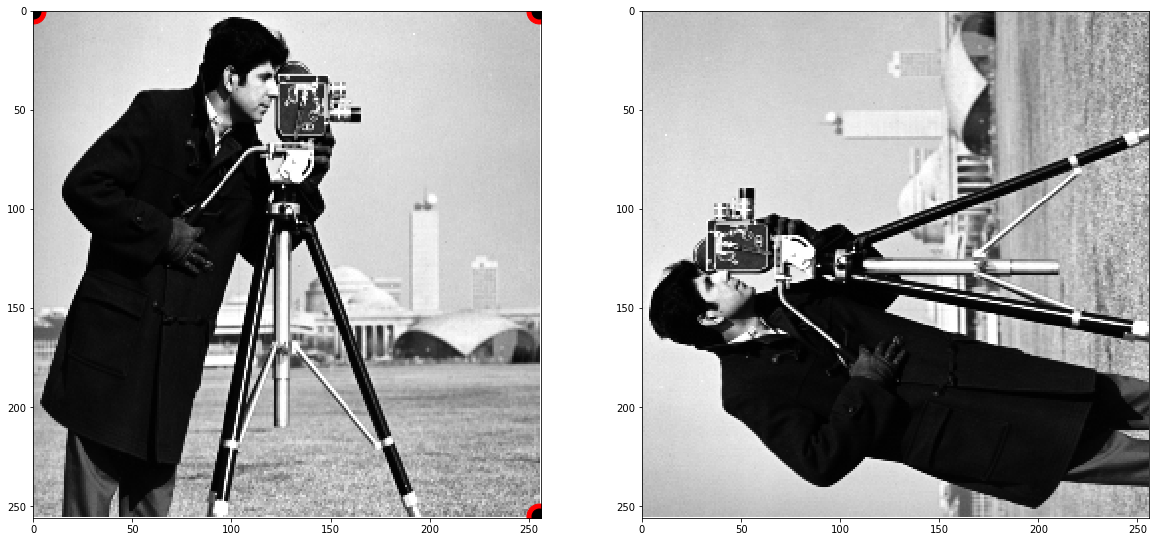

Shear using exact method


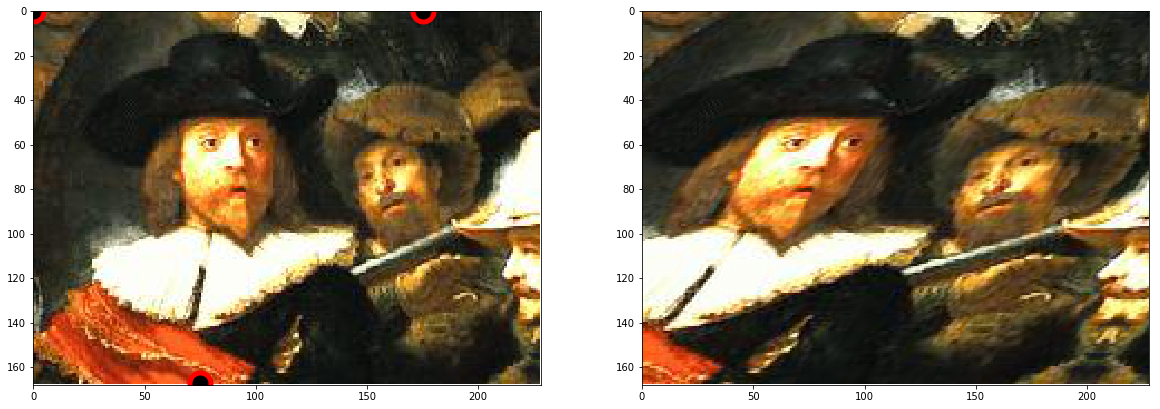

Shear using least squares estimator


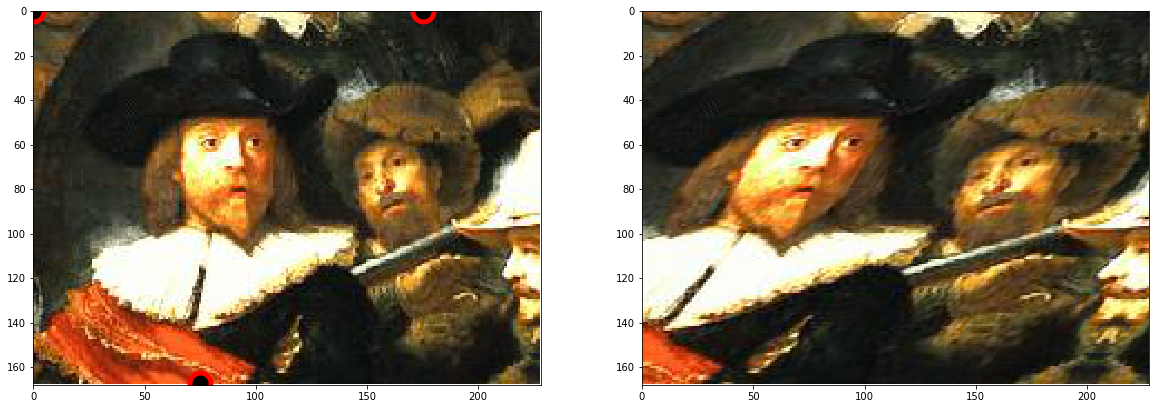

In [2]:
def affineTransform_lstsq(f, x1, y1, x2, y2, x3, y3, width, height, prnt=False):
    
    M = np.array([[x1, y1, 1, 0, 0, 0],
                  [0, 0, 0, x1, y1, 1],
                  [x2, y2, 1, 0, 0, 0],
                  [0, 0, 0, x2, y2, 1],
                  [x3, y3, 1, 0, 0, 0],
                  [0, 0, 0, x3, y3, 1]])
    
    q = array([0, 0, width - 1, 0, 0, height - 1])
    
    # Least squares estimater for p, take only p (lstsq returns multiple parameters)
    p = lstsq(M,q)[0]
    # Put into matrix form and add lower row (constant for affine transforms)
    A = p.reshape((2, 3))
    A = vstack((A, array([0, 0, 1])))
    # warp function asks for inverse of transformation matrix
    A_inv = inv(A)
    # Take quintic interpolation for cleanest effect and reflect boundary of image
    # otherwise target image has black borders.
    f_transf = warp(f, A_inv, order=5, mode='reflect')
    
    if prnt:
        print(A)
    
    return f_transf  

def affineTransform(f, x1, y1, x2, y2, x3, y3, width, height, prnt=False):
    
    M = np.array([[x1, y1, 1, 0, 0, 0],
                  [0, 0, 0, x1, y1, 1],
                  [x2, y2, 1, 0, 0, 0],
                  [0, 0, 0, x2, y2, 1],
                  [x3, y3, 1, 0, 0, 0],
                  [0, 0, 0, x3, y3, 1]])
    
    q = np.array([0, 0, width - 1, 0, 0, height - 1])
    
    # According to above listed method without using least squares estimator
    A = vstack((dot(inv(M), q).reshape((2, 3)), array([0, 0, 1])))
    # Inverting A for use in warp funtion
    A_inv = inv(A)
    # Taking quintic interpolation and reflecting the borders
    f_transf = warp(f, A_inv, order=5, mode='reflect')
    
    if prnt:
        print(A)
    
    return f_transf 

def place_marker(ax, x, y, sz):
    
    ax.plot(x, y, color='r', marker='o', markersize=sz)
    ax.plot(x, y, color='k', marker='o', markersize=sz-10)

def plot_image_affine(filename, a, func = affineTransform):
    
    f = imread(filename)
    rng_x, rng_y = len (f[0]), len(f)
    f_trans = func(f, a[0], a[1], a[2], a[3], a[4], a[5], rng_x, rng_y)

    fig, axarr = plt.subplots(1, 2)
    axarr[0].imshow(f, cmap='gray')
    axarr[0].set_xlim([0, rng_x])
    axarr[0].set_ylim([rng_y, 0])
    place_marker(axarr[0], a[0], a[1], 25)
    place_marker(axarr[0], a[2], a[3], 25)
    place_marker(axarr[0], a[4], a[5], 25)
    axarr[1].imshow(f_trans, cmap='gray')
    axarr[1].set_xlim([0, rng_x])
    axarr[1].set_ylim([rng_y, 0])

    plt.show()

# Test for square grayscale image rotation
print('Rotation')
args1 = [255, 0, 255, 255, 0, 0]
plot_image_affine('cameraman1.png', args1)

# Test for non-square color image shearing
args2 = [0, 0, 175, 0, 75, 167]
print('Shear using exact method')
plot_image_affine('nachtwacht1.jpg', args2, func = affineTransform)
print('Shear using least squares estimator')
plot_image_affine('nachtwacht1.jpg', args2, func = affineTransform_lstsq)

In the above section of code two affine transform functions have been defined, one using the least squares estimator and one using the exact method. Here we print A for an identity transform (doing nothing to the image) where we can see the difference between the least squares method and the exact method. While there doesn't seem to be much difference in the first two cases, there is a clear discrepancy in the third case fo the shear operation. From the above plots this does not seem to have an effect on the actual image as far as I can see.

Also it is interesting to note that a rotation, with the points chosen, has a matrix representation that shows it as arotation around the origin (0, 0) followed by a translation.

In [3]:
np.set_printoptions(precision=2)

# Testing equivalence for identity operation, exact vs least squares
f = imread('cameraman1.png')
print('Exact method for identity')
f_trans = affineTransform(f, 0, 0, 255, 0, 0, 255, 256, 256, prnt=True)
print('Least squares method for identity')
f_trans = affineTransform_lstsq(f, 0, 0, 255, 0, 0, 255, 256, 256, prnt=True)
print()

# Testing the equivalence of pure rotation, exact vs least squares
print('Exact method for rotation')
f_trans = affineTransform(f, 255, 0, 255, 255, 0, 0, 256, 256, prnt=True)
print('Least squares method for rotation')
f_trans = affineTransform_lstsq(f, 255, 0, 255, 255, 0, 0, 256, 256, prnt=True)
print()

# Testing equivalence for shear operation
f = imread('nachtwacht1.jpg')
print('Exact method for shear')
f_trans = affineTransform(f, 0, 0, 175, 0, 75, 167, 256, 256, prnt=True)
print('Least squares method for shear')
f_trans = affineTransform_lstsq(f, 0, 0, 175, 0, 75, 167, 167, 238, prnt=True)

Exact method for identity
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Least squares method for identity
[[  1.00e+00   0.00e+00   8.94e-19]
 [  3.02e-16   1.00e+00  -1.93e-14]
 [  0.00e+00   0.00e+00   1.00e+00]]

Exact method for rotation
[[   0.    1.    0.]
 [  -1.    0.  255.]
 [   0.    0.    1.]]
Least squares method for rotation
[[  0.00e+00   1.00e+00  -2.18e-18]
 [ -1.00e+00  -2.05e-17   2.55e+02]
 [  0.00e+00   0.00e+00   1.00e+00]]

Exact method for shear
[[ 1.46 -0.65  0.  ]
 [ 0.    1.53  0.  ]
 [ 0.    0.    1.  ]]
Least squares method for shear
[[  9.49e-01  -4.26e-01   2.44e-15]
 [ -2.36e-16   1.42e+00  -6.02e-15]
 [  0.00e+00   0.00e+00   1.00e+00]]


## Perspective transform

The next level of transformations is given by the perspective transform, which is the most general transformation on homogeneous coordinates represented by a matrix 

\begin{split}
P = \vecl{a&b&c\\d&e&f\\g&h&i}
\end{split}

which, working on homogeneous coordinates gives

\begin{split}
s \hvec{x}' = \vecl{a&b&c\\d&e&f\\g&h&i}\hvec{x}
\end{split}

where s is now the scaling factor which is not conserved by this transformation due to the bottom row of the matrix. By taking this into account we can rewrite this equation as 

\begin{split}
-x' \left( gx + hy + i \right) + ax + by + c = 0 \\
-y' \left( gx + hy + i \right) + dx + ey + f = 0
\end{split}

and recast this into a system of linear equations for $x \rightarrow x_i$ and $y \rightarrow y_i$ in matrix form for 4 transformation points

\begin{split}
\vecl{x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1'x_1 & -x_1'y_1 & -x_1'\\
      0 & 0 & 0 & x_1 & y_1 & 1 & -y_1'x_1 & -y_1'y_1 & -y_1'\\
      x_2 & y_2 & 1 & 0 & 0 & 0 & -x_2'x_2 & -x_2'y_2 & -x_2'\\
      0 & 0 & 0 & x_2 & y_2 & 1 & -y_2'x_2 & -y_2'y_2 & -y_2'\\
      x_3 & y_3 & 1 & 0 & 0 & 0 & -x_3'x_3 & -x_3'y_3 & -x_3'\\
      0 & 0 & 0 & x_3 & y_3 & 1 & -y_3'x_3 & -y_3'y_3 & -y_3'\\
      x_4 & y_4 & 1 & 0 & 0 & 0 & -x_4'x_4 & -x_4'y_4 & -x_4'\\
      0 & 0 & 0 & x_4 & y_4 & 1 & -y_4'x_4 & -y_4'y_4 & -y_4'} 
\vecl{a\\b\\c\\d\\e\\f\\g\\h\\i } &= 
\vecl{0\\0\\0\\0\\0\\0\\0\\0\\0 } \\
M \nvec{p} &= 0
\end{split}

if the chosen points are not collinear this system has a solution and can be found by calculating the null space of the matrix M. Since we want this to work in the most general sense possible, we want to be able to choose more than 4 points. This is because only 4 points might have measurement error and in certain situations it will be better to have more than 4 points. It may not be guaranteed that there are even any vectors in the null space of the matrix M. Because of this we want to use Singular Value Decomposition (SVD) to minimize the vector $\nvec{p}$ to get as close as possible to the 0 vector.

To do this we have to add one constraint such that a trivial solution is not possible, we want to minimize $\nvec{p}$ subject to $\left| \nvec{p} \right| = 1$, this way the 0 vector itself is not a solution and since the null space is itself a vector space we can always find a vector that satisfies this constraint.

Using SVD we decompose the matrix M into it's components given by

\begin{split}
UDV^T = M
\end{split}

if M is a 2n x 9 matrix then $U$ is a 2n x 2n square orthonormal matrix, $D$ is a 2n x 9 'diagonal' matrix and $V^T$ is a 9 x 9 square orthonormal matrix. The condition for minimizing $\nvec{p}$ is then 

\begin{split}
\text{min} \left|\left| UDV^T\nvec{p} \right|\right| \quad \text{s.t.} \quad \left| \nvec{p} \right| = 1
\end{split}

since $U$ and $V^T$ are orthogonal matrices they preserve the norm or the vector they work on and thus we can simplify the equation to

\begin{split}
\text{min} \left|\left| D\nvec{q} \right|\right| \quad \text{s.t.} \quad \left| \nvec{q} \right| &= 1 \\
\text{with} \quad \nvec{q} &= V^{T} \nvec{p}
\end{split}

Since D is a diagonal matrix with singular values on the diagonal in descending order this equation is minimized for $\nvec{q}^T = \vecl{0&0&..&0&1}$ which picks out the last column of $V$ where the smallest singular value is. The condition of $\left| \nvec{p} \right| = 1$ is automatically fulfilled since $V$ is an orthonormal matrix.

In the algorithm below the last row of $V^T$ has been taken to eliminate the need for an additional inversion of $V$. The first point is marked by a black dot and the rest of the points are found by following the red line. Different ordering of the points can give some funky perspective effects which are generally not very useful. 

Basic perspective test on grayscale image


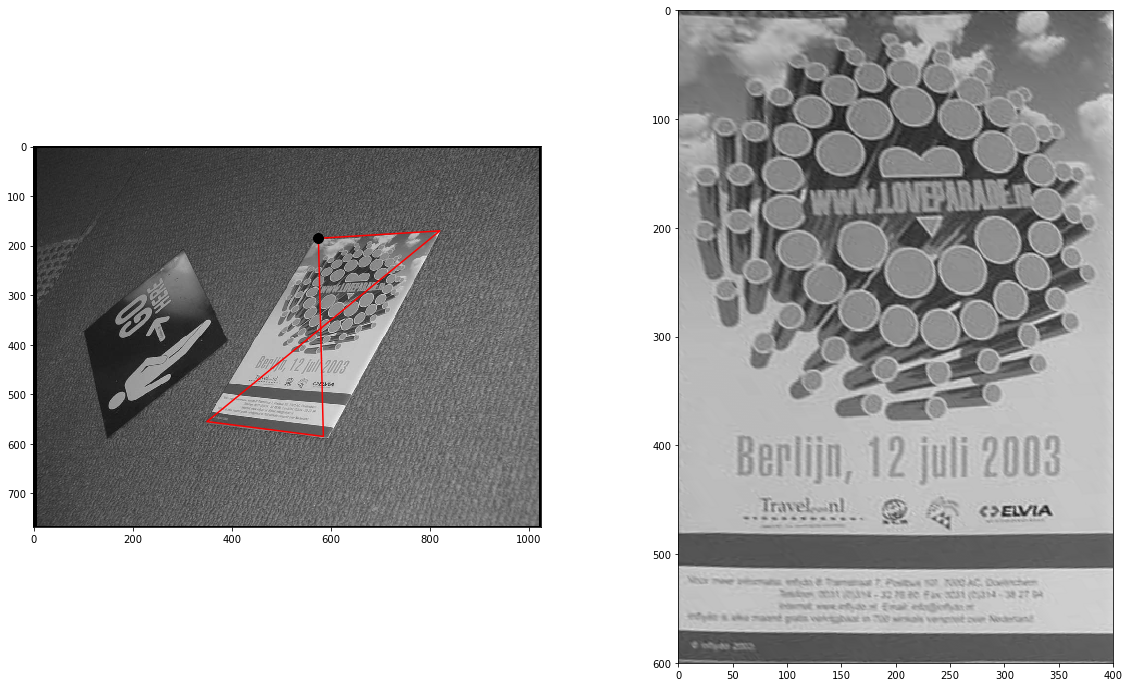

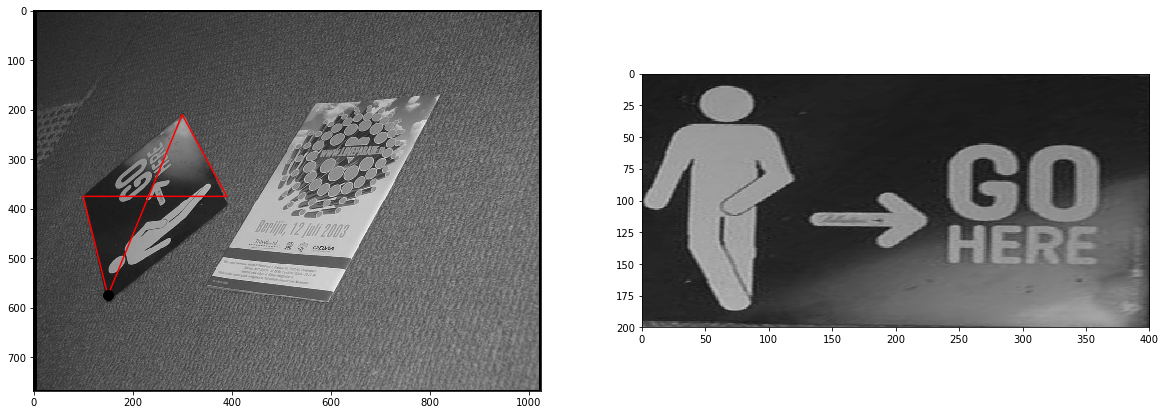

Perspective test on computer screen


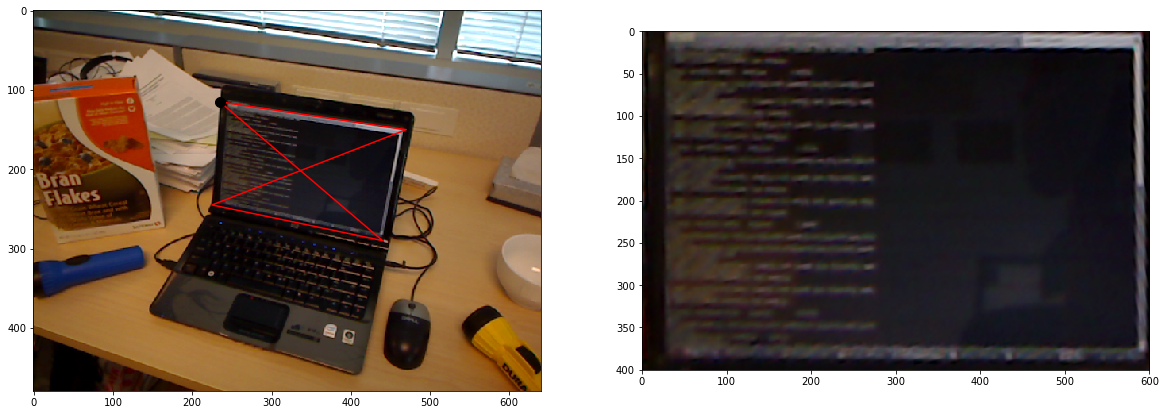

Perspective color test


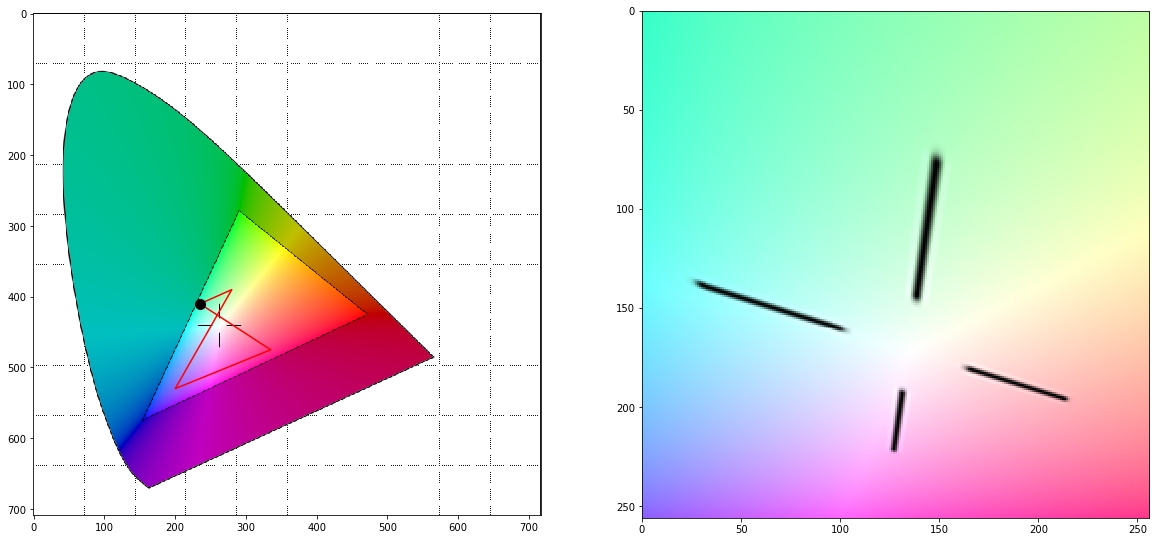

In [4]:
def perspectiveTransform(f, x1, y1, x2, y2, x3, y3, x4, y4, width, height):
    
    x1_p, y1_p = 0, 0
    x2_p, y2_p = width - 1, 0
    x3_p, y3_p = 0, height - 1
    x4_p, y4_p = width - 1, height - 1
    
    M = np.array([[x1, y1, 1, 0, 0, 0, -x1 * x1_p, -x1_p * y1, -x1_p],
                  [0, 0, 0, x1, y1, 1, -x1 * y1_p, -y1_p * y1, -y1_p],
                  [x2, y2, 1, 0, 0, 0, -x2 * x2_p, -x2_p * y2, -x2_p],
                  [0, 0, 0, x2, y2, 1, -x2 * y2_p, -y2_p * y2, -y2_p],
                  [x3, y3, 1, 0, 0, 0, -x3 * x3_p, -x3_p * y3, -x3_p],
                  [0, 0, 0, x3, y3, 1, -x3 * y3_p, -y3_p * y3, -y3_p],
                  [x4, y4, 1, 0, 0, 0, -x4 * x4_p, -x4_p * y4, -x4_p],
                  [0, 0, 0, x4, y4, 1, -x4 * y4_p, -y4_p * y4, -y4_p]])
    
    U, D, V_t = np.linalg.svd(M)
    # Takin the last row of V_t (same as last column of V) and reshape to 3x3 matrix
    p = V_t[-1].reshape((3, 3))
    # Warp image using transformation matrix, order has been taken as bicubic since higher orders only
    # introduce longer calculation time without noticeable improvement in quality.
    f_trans = warp(f, np.linalg.inv(p), order=3, mode='reflect')
    return f_trans

def plot_image_perspective(filename, a):
    
    f = imread(filename)
    f_trans = perspectiveTransform(f, a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9])

    fig, axarr = plt.subplots(1, 2)
    axarr[0].imshow(f, cmap='gray')
    # Plot square of chosen initial coodinates
    axarr[0].plot([a[0], a[2], a[4], a[6], a[0]], [a[1], a[3], a[5], a[7], a[1]], color='r')
    axarr[0].plot(a[0], a[1], color='k', marker='o', markersize=10)
    axarr[1].imshow(f_trans, cmap='gray')
    axarr[1].set_xlim([0, a[8]])
    axarr[1].set_ylim([a[9], 0])
    plt.show()

print('Basic perspective test on grayscale image')
args1 = [575, 185, 820, 170, 350, 555, 585, 585, 400, 600]
plot_image_perspective('flyeronground.png', args1)
args2 = [150, 575, 100, 375, 390, 375, 300, 210, 400, 200]
plot_image_perspective('flyeronground.png', args2)
print('Perspective test on computer screen')
args3 = [235, 115, 470, 150, 225, 245, 440, 290, 600, 400]
plot_image_perspective('desk_3_27.png', args3)
print('Perspective color test')
args4 = [235, 410, 280, 390, 200, 530, 335, 475, 256, 256]
plot_image_perspective('screen_info.png', args4)